# Graph Isomorphism

This jupyter notebook is part of a series of notebooks that contain code to generate the results of this [REFERENCE] paper. Here we focus on application to the graph isomorphism problem. The structure is the following:
- Random graph generation and other functions to prepare the calculations (*to_unitary()*, state preparation and many others).
- *is_isomorphic_p()* and *is_isomorphic_l()* functions to test isomorphism with the two different possibilities approached: with the permanental polynomials and with the Laplacian respectively.
- Some tests.

In [22]:
import numpy as np
from numpy import linalg
from scipy.linalg import sqrtm
import networkx as nx
import math

import perceval as pcvl
import matplotlib.pyplot as plt


In [23]:
import functions

Now that we have the the basic functions (from previous notebook in the series), we go into the *is_isomorphic_p()* and *is_isomorphic_l()* functions that tell us if two input graphs are isomorphic. They differ only by using the simpler first approach with permanental polynomials or using the better distinguisher, the Laplacian.

In [24]:
def order_of_magnitude(number):
    return math.floor(math.log(number, 10))

In [25]:
def is_isomorphic_p(A, B, Ns, error=0.1, Ns_min=100, eps=10):
    '''Input: A and B - networkX graphs to test 
              Ns - number of samples to generate with quantum device for each cycle (depends on the minimum number of samples we want for the estimation)
              error - default value for estimation; represents the order of magnitude to which the two permanents must be compared to
              Ns_min - minimum number of accepted samples after post-selection. This is the minimum number on the numenator of permanent estimation
    return: boolean value for being isomorphic or not'''

    # Initialization - number of modes, graph decomposition, input state
    if type(A) == type(nx.Graph()):
        m = A.number_of_nodes()
        A = nx.to_numpy_array(A)
        B = nx.to_numpy_array(B)

    else:
        m = len(A)
    inputState = functions.input_state(m)
    epsilon = eps*m*np.random.rand(m)
    Sampling_Backend = pcvl.BackendFactory().get_backend("CliffordClifford2017")

    for i in epsilon:
        # preparing the device and generating samples
        UA, cA = functions.to_unitary(A+i*np.identity(m))
        UB, cB = functions.to_unitary(B+i*np.identity(m))

        UA = pcvl.Matrix(UA)
        UB = pcvl.Matrix(UB)
        simulatorA = Sampling_Backend(UA)
        simulatorB = Sampling_Backend(UB)

        # generate samples and are continuously generating until we reach a minimum value of valid samples
        samplesA = []
        samplesB = []
        j = 0
        while len(samplesA) < Ns_min or len(samplesB) < Ns_min:
            for _ in range(Ns):
                samplesA.append(
                    list(simulatorA.sample(pcvl.BasicState(inputState))))
                samplesB.append(
                    list(simulatorB.sample(pcvl.BasicState(inputState))))
            samplesA = functions.post_select(samplesA)
            samplesB = functions.post_select(samplesB)
            j = j+1

        permA = (cA**m)*np.sqrt(len(samplesA)/(Ns*i))
        permB = (cB**m)*np.sqrt(len(samplesB)/(Ns*i))
        #numError = 10**order_of_magnitude(max(permA, permB))*error
        numError = max(permA, permB)*error
        #print("N - permanent(A): ",permA, "; permanent(B): ",permB, "numError: ", numError)
        if abs(permA - permB) > numError:
            return False
    return True


In [26]:
def is_isomorphic_l(A, B, Ns, error=0.1, Ns_min=100, eps=10):
    '''Input: A and B - networkX graphs to test 
              Ns - number of samples to generate with quantum device for each cycle (depends on the minimum number of samples we want for the estimation)
              error - default value for estimation; represents the order of magnitude to which the two permanents must be compared to
              Ns_min - minimum number of accepted samples after post-selection. This is the minimum number on the numenator of permanent estimation
    return: boolean value for being isomorphic or not'''

    # Initialization - number of modes, graph decomposition, input state
    if type(A) == type(nx.Graph()):
        m = A.number_of_nodes()
        LA = np.diag([A.degree(i) for i in range(m)]) - nx.to_numpy_array(A)
        LB = np.diag([B.degree(i) for i in range(m)]) - nx.to_numpy_array(B)

    else:
        m = len(A)
        LA = np.diag([sum(A[i]) for i in range(m)]) - A
        LB = np.diag([sum(B[i]) for i in range(m)]) - B
    inputState = functions.input_state(m)
    epsilon = eps*m*np.random.rand(m)
    Sampling_Backend = pcvl.BackendFactory().get_backend("CliffordClifford2017")

    for i in epsilon:
        # preparing the device and generating samples
        UA, cA = functions.to_unitary(LA+i*np.identity(m))
        UB, cB = functions.to_unitary(LB+i*np.identity(m))

        UA = pcvl.Matrix(UA)
        UB = pcvl.Matrix(UB)
        simulatorA = Sampling_Backend(UA)
        simulatorB = Sampling_Backend(UB)

        # we generate samples and are continuously generating until we reach a minimum value of valid samples
        samplesA = []
        samplesB = []
        j = 0
        while len(samplesA) < Ns_min or len(samplesB) < Ns_min:
            for _ in range(Ns):
                samplesA.append(list(simulatorA.sample(pcvl.BasicState(inputState))))
                samplesB.append(list(simulatorB.sample(pcvl.BasicState(inputState))))
            samplesA = functions.post_select(samplesA)
            samplesB = functions.post_select(samplesB)
            j = j + 1

        permA = (cA**m)*np.sqrt(len(samplesA)/(Ns*i))
        permB = (cB**m)*np.sqrt(len(samplesB)/(Ns*i))
        #numError = 10**order_of_magnitude(max(permA, permB))*error
        numError = max(permA, permB)*error
        #print("N - permanent(A): ",permA, "; permanent(B): ",permB, "numError: ", numError)
        if abs(permA - permB) > numError:
            return False
    return True


You can now test the algorithm! You can either test separatly two graphs at a time like following example or test over an arbitrary amount you like to estimate the algorithm accuracy (as paper results over 100 tries). Note that the results over 100 graphs might take a long time to run.

CPU times: user 5.91 s, sys: 48.8 ms, total: 5.96 s
Wall time: 6.05 s


True

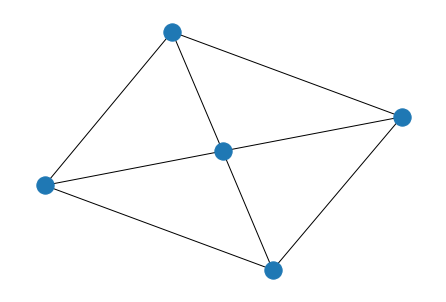

In [16]:
%%time
Ns=2000
GA=functions.random_graph_generation(5, 0.8)
GB=functions.random_graph_generation(5, 0.8)
nx.draw(GA)
is_isomorphic_l(GA, GB, Ns, Ns_min=500, error=0.1)

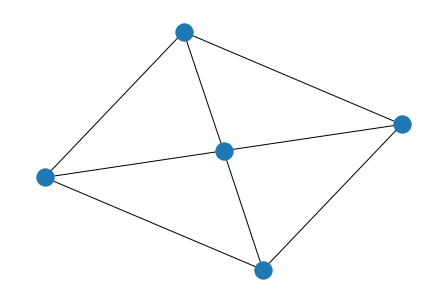

In [17]:
nx.draw(GB)

Now we can test over a lot of runs to see how accurate our program is. For this, we used the function *is_isomorphic()* from NetworkX as the truth statement to do benchmark our results.

In [10]:
Ns = 2000
equal = 0
diff = 0
L = 0
P = 0
for i in range(100):
    GA = functions.random_graph_generation(5, 0.8)
    GB = functions.random_graph_generation(5, 0.8)
    isomBoolean = is_isomorphic_p(GA, GB, Ns, Ns_min=500, error=0.1)  # ; print("\n")
    isomBooleanL = is_isomorphic_l(GA, GB, Ns, Ns_min=500, error=0.1)
    print(nx.is_isomorphic(GA, GB), ", Permanental encoding: ",
          isomBoolean, ", Laplacian encoding: ", isomBooleanL)
    if nx.is_isomorphic(GA, GB) == isomBoolean == isomBooleanL: 
        equal = equal + 1
    elif nx.is_isomorphic(GA, GB) == isomBoolean: P = P + 1
    elif nx.is_isomorphic(GA, GB) == isomBooleanL: L = L + 1
    else: diff = diff + 1
print("\nSummary:\nequal", equal, "diff", diff, "Only Laplacian got it right:",
      L, "Only Permanental got it:", P)

True , Permanental encoding:  False , Laplacian encoding:  True
False , Permanental encoding:  False , Laplacian encoding:  False
True , Permanental encoding:  False , Laplacian encoding:  True
False , Permanental encoding:  False , Laplacian encoding:  False
False , Permanental encoding:  False , Laplacian encoding:  False
False , Permanental encoding:  False , Laplacian encoding:  False
False , Permanental encoding:  False , Laplacian encoding:  False
False , Permanental encoding:  True , Laplacian encoding:  True
False , Permanental encoding:  False , Laplacian encoding:  False
True , Permanental encoding:  True , Laplacian encoding:  True
False , Permanental encoding:  False , Laplacian encoding:  False
False , Permanental encoding:  False , Laplacian encoding:  False
False , Permanental encoding:  True , Laplacian encoding:  False
True , Permanental encoding:  True , Laplacian encoding:  True
False , Permanental encoding:  True , Laplacian encoding:  False
True , Permanental encod

In [29]:
Ns = 2000
equal = 0
diff = 0
L = 0
P = 0
for i in range(100):
    GA = functions.random_graph_generation(5, 0.9)
    GB = functions.random_graph_generation(5, 0.7)
    isomBoolean = is_isomorphic_p(GA, GB, Ns, Ns_min=500, error=0.1)#; print("\n")
    isomBooleanL = is_isomorphic_l(GA, GB, Ns, Ns_min=500, error=0.1)
    print(nx.is_isomorphic(GA, GB), ", Permanental encoding: ", isomBoolean, ", Laplacian encoding: ", isomBooleanL)
    if nx.is_isomorphic(GA, GB) == isomBoolean == isomBooleanL:
        equal = equal + 1
    elif nx.is_isomorphic(GA, GB) == isomBoolean: P = P + 1
    elif nx.is_isomorphic(GA, GB) == isomBooleanL: L = L + 1
    else: diff = diff + 1
print("\nSummary:\nequal", equal, "diff", diff, "Only Laplacian got it right:", L, "Only Permanental got it:", P)

True , Permanental encoding:  True , Laplacian encoding:  True
False , Permanental encoding:  False , Laplacian encoding:  False
False , Permanental encoding:  True , Laplacian encoding:  True
True , Permanental encoding:  True , Laplacian encoding:  True
False , Permanental encoding:  True , Laplacian encoding:  False
False , Permanental encoding:  False , Laplacian encoding:  False
False , Permanental encoding:  True , Laplacian encoding:  False
False , Permanental encoding:  False , Laplacian encoding:  False
False , Permanental encoding:  False , Laplacian encoding:  False
False , Permanental encoding:  True , Laplacian encoding:  False
False , Permanental encoding:  False , Laplacian encoding:  False
False , Permanental encoding:  True , Laplacian encoding:  False
False , Permanental encoding:  False , Laplacian encoding:  False
True , Permanental encoding:  True , Laplacian encoding:  True
False , Permanental encoding:  False , Laplacian encoding:  False
False , Permanental encod

In [28]:
Ns = 2000
equal = 0
diff = 0
L = 0
P = 0
for i in range(100):
    TA = nx.random_tree(5)
    TB = nx.random_tree(5)
    isomBoolean = is_isomorphic_p(TA, TB, Ns, Ns_min=500, error=0.1)#; print("\n")
    isomBooleanL = is_isomorphic_l(TA, TB, Ns, Ns_min=500, error=0.1)
    print(nx.is_isomorphic(TA, TB), ", Permanental encoding: ", isomBoolean, ", Laplacian encoding: ", isomBooleanL)
    if nx.is_isomorphic(TA, TB) == isomBoolean == isomBooleanL:
        equal = equal + 1
    elif nx.is_isomorphic(TA, TB) == isomBoolean: P = P + 1
    elif nx.is_isomorphic(TA, TB) == isomBooleanL: L = L + 1
    else: diff = diff + 1
print("\nSummary:\nequal", equal, "diff", diff, "Only Laplacian got it right:", L, "Only Permanental got it:", P)

False , Permanental encoding:  True , Laplacian encoding:  True
False , Permanental encoding:  True , Laplacian encoding:  True
False , Permanental encoding:  True , Laplacian encoding:  True
False , Permanental encoding:  True , Laplacian encoding:  True
True , Permanental encoding:  True , Laplacian encoding:  True
True , Permanental encoding:  True , Laplacian encoding:  True
False , Permanental encoding:  True , Laplacian encoding:  True
False , Permanental encoding:  False , Laplacian encoding:  True
False , Permanental encoding:  True , Laplacian encoding:  True
True , Permanental encoding:  True , Laplacian encoding:  True
True , Permanental encoding:  True , Laplacian encoding:  True
True , Permanental encoding:  True , Laplacian encoding:  True
True , Permanental encoding:  True , Laplacian encoding:  True
True , Permanental encoding:  True , Laplacian encoding:  True
True , Permanental encoding:  True , Laplacian encoding:  True
False , Permanental encoding:  True , Laplacian

As a small conclusion for these results, we have that:
 - The Laplacian is indeed a better distinguisher as refered in the paper
 - Neither one of the distinguishers (*is_isomorphic_p()* or *is_isomorphic_l()*) are able to compute isomorphism when it comes to trees however the results for random graphs with similar characteristics where quite satisfactory.